In [1]:
#Dependencies
import numpy as np
import pylab as pl
import tensorflow as tf
import matplotlib.pyplot as plt

import utils.plotutils as plu
import utils.imreadin as imr

%matplotlib inline

In [2]:
#Model Parameters
compression = 500
patchsize = 16
batchsize = 50
iterations = 1000
testiterations = 50

#noise
noisexsigma = 0 #1e-4
noisersigma = 0 #1e-4


#to keep covariance matrix small for now
npatchestotal =  iterations*batchsize #np.int(1e6)

#lambdaj = 1e-5 #this is adjusted in order to get ravg = 1
#ravg = 1

minact = 0.1 #5e-1
minslo = 0.1 #1e-1
#bslfr = 1e-1

learning_rate = 0.1

In [3]:
#Load in images if we haven't yet.
try:
    vhims
except NameError:
    print("Loading Van Hateren Natural Image Database...")
    vhims = imr.vanHateren(
        img_dir='../vanHaterenNaturalImages/VanHaterenNaturalImagesCurated.h5',
        #normalize = True
        #patch_edge_size=patchsize
        )
    print("Done Loading!")    
    #np.random.shuffle(vhims.images)
    print("Done Shuffling!")
    
    ##reduce images so we only hold in memory the ones we're using
    #vhims.images = vhims.images[0:npatchestotal]
    
print("Images Loaded. Carry On!")

#code to save if i had enough hd space. i shold buy a new computer.
#f=open('../vanHaterenNaturalImages/vhnormpatches_{}.npy'.format(patchsize),'wb')
#np.save(f,vhims)
#f.close()

#params of images
imxlen = len(vhims.images[0,0,:])
imylen = len(vhims.images[0,:,0])

nneurons = np.int(imxlen*imylen/compression)

Loading Van Hateren Natural Image Database...
Done Loading!
Done Shuffling!
Images Loaded. Carry On!


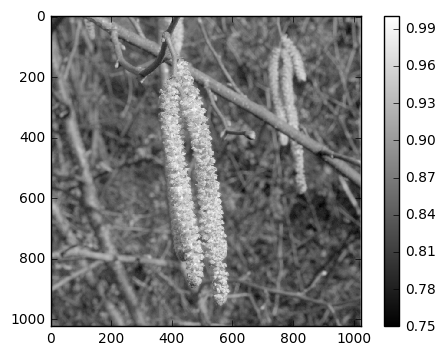

In [4]:
#show an example image
plt.imshow(vhims.images[30],cmap='gray',interpolation='none')
plt.colorbar()

In [5]:
#input image
x = tf.placeholder(tf.float32, shape=(batchsize, imxlen*imylen),name='input_image')
#output image
xp = tf.placeholder(tf.float32, shape=(batchsize,imxlen*imylen),name='output_image')

#noise
nxc = noisexsigma**2
nrc = noisersigma**2
nx = tf.constant(nxc,dtype=tf.float32,name='input_noise')
nr = tf.constant(nrc,dtype=tf.float32,name='internal_noise')

#weights
win = tf.Variable(tf.random_normal([imxlen*imylen,nneurons],dtype=tf.float32,stddev=1),name='weights_in')
#wout = tf.placeholder(tf.float32, shape=np.shape(win),name='weights_out')

#calculate inner layer
y = tf.nn.tanh(tf.matmul(tf.add(x, nx),win))
#calculate ouer layer
xp = tf.nn.tanh(tf.matmul(y,tf.transpose(win)))
#calculate cost
cost = tf.sqrt(tf.reduce_mean(tf.square(x-xp)))

train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

In [ ]:
#run it!
#sess = tf.Session
with tf.Session() as sess:
    #initialize vars
    init = tf.global_variables_initializer()
    sess.run(init)
    
    #save evolution of system over training
    cost_evolution = []
    weights_evolution = []
    
    hist = {}
    
    #train over niterations
    nits = iterations #full run
    nits = testiterations #test run
    
    print('Training {} iterations...'.format(nits))
    for ii in range(nits):
        if(ii%(int(nits/10))==0):
            print(str(ii)+', ',end="")
        image = np.reshape(vhims.images[ii*batchsize:(1+ii)*batchsize,:,:],(batchsize,imxlen*imylen)).T.astype(np.float32)
        #noise_input = np.random.normal(0,noisexsigma,[patchsize**2,batchsize]).astype(np.float32)*0.
        #noise_response = np.random.normal(0,noisersigma,[nneurons,batchsize]).astype(np.float32)*0.
        hist[0] = image
        info = sess.run(information, feed_dict={x:image})
        sess.run(train_step, feed_dict={x:image})
        
        #save evolution of params
        objcost = sess.run(cost, feed_dict={x:image})
        objective_evolution.append(objcost)
        weightsr = sess.run(win, feed_dict={x:image})
        weights_evolution.append(np.std(weightsr))
        #if ii%iterations == 0:
            #pass
        
    #print statements
    #myweights = w.eval()
    #print(myweights)
    #myrlus = reluslope.eval()
    #print(myrlus)
    #myrluof = reluoff.e`val()
    #print(myrluof)
    #myrs = r.eval()
    #print(myrs)
    #myobjective = objective.eval()
    #print(myobjective)
    weights = sess.run(win, feed_dict={x:image})
    print('Done!')

In [ ]:
wr = np.rollaxis(np.reshape(weights,(patchsize,patchsize,nneurons)),2)
plu.display_data_tiled(wr, normalize=False, title="weights", prev_fig=None)